# Measuring Hate Speech in Digital Text
##### The goal of this project is to use a Linear Regression supervised learning model to predict the Hate Speech 'score' of a text data source (tweet) using an annotated dataset of tweets. 
Predicting hate speech, or abusive speech, in digital text is a key business problem for any online community platform, whether it's social media, forums, video games, etc. Abusive communication from users can drive down platform use, leading to product shrinkage. 

In [1]:
import numpy as np
import scipy as sp

#Visualization libraries
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

#Pandas dataframes
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

#NLP libraries
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords

## Data Wrangling
Import HateSpeech dataset

In [2]:
'''
@article{kennedy2020constructing,
  title={Constructing interval variables via faceted Rasch measurement and multitask deep learning: a hate speech application},
  author={Kennedy, Chris J and Bacon, Geoff and Sahn, Alexander and von Vacano, Claudia},
  journal={arXiv preprint arXiv:2009.10277},
  year={2020}
}'''

'\n@article{kennedy2020constructing,\n  title={Constructing interval variables via faceted Rasch measurement and multitask deep learning: a hate speech application},\n  author={Kennedy, Chris J and Bacon, Geoff and Sahn, Alexander and von Vacano, Claudia},\n  journal={arXiv preprint arXiv:2009.10277},\n  year={2020}\n}'

In [3]:
import datasets 
dataset = datasets.load_dataset('ucberkeley-dlab/measuring-hate-speech', 'binary')   
df = dataset['train'].to_pandas()
df.describe()

Using custom data configuration ucberkeley-dlab--measuring-hate-speech-7cb9b0b8e4d0e1dd
Reusing dataset parquet (C:\Users\DP185257\.cache\huggingface\datasets\parquet\ucberkeley-dlab--measuring-hate-speech-7cb9b0b8e4d0e1dd\0.0.0\0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901)


  0%|          | 0/1 [00:00<?, ?it/s]

,comment_id,annotator_id,platform,sentiment,respect,insult,humiliate,status,dehumanize,violence,genocide,attack_defend,hatespeech,hate_speech_score,infitms,outfitms,annotator_severity,std_err,annotator_infitms,annotator_outfitms,hypothesis,annotator_age
count,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.00000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135451.000000
mean,23530.416138,5567.097812,1.281352,2.954307,2.828875,2.56331,2.278638,2.698575,1.846211,1.052045,0.678413,2.625992,0.744733,-0.567428,1.034322,1.001052,-0.018817,0.300588,1.007158,1.011841,0.014589,37.910772
std,12387.194125,3230.508937,1.023542,1.231552,1.309548,1.38983,1.370876,0.898500,1.402372,1.345706,1.179598,1.114960,0.932260,2.380003,0.496867,0.791943,0.487261,0.236380,0.269876,0.675863,0.613006,11.641276
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-8.340000,0.100000,0.070000,-1.820000,0.020000,0.390000,0.280000,-1.578693,18.000000
25%,18148.000000,2719.000000,0.000000,2.000000,2.000000,2.00000,1.000000,2.000000,1.000000,0.000000,0.000000,2.000000,0.000000,-2.330000,0.710000,0.560000,-0.380000,0.030000,0.810000,0.670000,-0.341008,29.000000
50%,20052.000000,5602.500000,1.000000,3.000000,3.000000,3.00000,3.000000,3.000000,2.000000,0.000000,0.000000,3.000000,0.000000,-0.340000,0.960000,0.830000,-0.020000,0.340000,0.970000,0.850000,0.110405,35.000000
75%,32038.250000,8363.000000,2.000000,4.000000,4.000000,4.00000,3.000000,3.000000,3.000000,2.000000,1.000000,3.000000,2.000000,1.410000,1.300000,1.220000,0.350000,0.420000,1.170000,1.130000,0.449555,45.000000
max,50070.000000,11142.000000,3.000000,4.000000,4.000000,4.00000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,2.000000,6.300000,5.900000,9.000000,1.360000,1.900000,2.010000,9.000000,0.987511,81.000000


In [4]:
df.shape

(135556, 131)

Drop all non-core data features from original data set, sort by Comment_ID

In [5]:
target_cols=['hate_speech_score', 'text', 'comment_id', 'annotator_id', 'sentiment', 'respect', 'insult', 'humiliate', 'status', 'dehumanize', 'violence', 'genocide', 'attack_defend', 'hatespeech', 'annotator_severity']
df_focus= df[target_cols].sort_values(by=['comment_id'])
df_focus.head()

,hate_speech_score,text,comment_id,annotator_id,sentiment,respect,insult,humiliate,status,dehumanize,violence,genocide,attack_defend,hatespeech,annotator_severity
70119,0.46,White people are trash.,1,712,4.0,4.0,4.0,3.0,4.0,3.0,0.0,0.0,3.0,0.0,0.44
50410,0.46,White people are trash.,1,8185,3.0,3.0,3.0,3.0,3.0,3.0,0.0,0.0,3.0,0.0,-0.61
1064,0.46,White people are trash.,1,3330,4.0,3.0,3.0,3.0,3.0,2.0,1.0,0.0,3.0,0.0,0.18
23298,0.46,White people are trash.,1,962,4.0,4.0,3.0,2.0,3.0,3.0,0.0,0.0,4.0,0.0,0.10
36676,0.03,"You've caught the big gay, it's known to be ai...",2,4328,4.0,4.0,4.0,3.0,3.0,2.0,0.0,0.0,3.0,2.0,0.06


Check for missing data

In [6]:
df_focus.isna().sum()

hate_speech_score     0
text                  0
comment_id            0
annotator_id          0
sentiment             0
respect               0
insult                0
humiliate             0
status                0
dehumanize            0
violence              0
genocide              0
attack_defend         0
hatespeech            0
annotator_severity    0
dtype: int64

## Exploratory Data Analysis
There isn't much to explore in this data. We are interested specifically in the text content of the tweets and the words therein. Other target features (sub scores) will be dropped and there will be focus only on the corpus and each articles hate_speech_score
#### Visualization of target variable (Y) hate_speech_score

array([[<AxesSubplot:title={'center':'hate_speech_score'}>]], dtype=object)

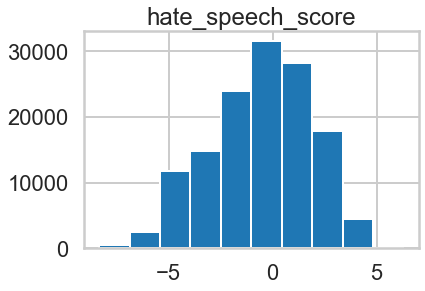

In [7]:
df_focus.hist('hate_speech_score')

Further drop the score columns, keeping only the target variable hate_speech_score

In [8]:
target_cols=['hate_speech_score', 'text']
df_text= df_focus[target_cols].reset_index(drop=True)
df_text.head()

,hate_speech_score,text
0,0.46,White people are trash.
1,0.46,White people are trash.
2,0.46,White people are trash.
3,0.46,White people are trash.
4,0.03,"You've caught the big gay, it's known to be ai..."


#### Now that the data is imported and appropriately formatted, we can begin on 
## Pre-processing Text

Remove all special characters, English stop words, and lowering case for all text

In [9]:
# necessary nltk downloads
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DP185257\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DP185257\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [10]:
import re
df_text['clean_text'] = df_text['text'].str.replace('[^a-zA-Z ]', '')
df_text['clean_text'] = df_text['clean_text'].str.lower()
df_text.head()

C:\Users\DP185257\AppData\Local\Temp/ipykernel_20192/3502143653.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df_text['clean_text'] = df_text['text'].str.replace('[^a-zA-Z ]', '')


,hate_speech_score,text,clean_text
0,0.46,White people are trash.,white people are trash
1,0.46,White people are trash.,white people are trash
2,0.46,White people are trash.,white people are trash
3,0.46,White people are trash.,white people are trash
4,0.03,"You've caught the big gay, it's known to be ai...",youve caught the big gay its known to be airbo...


### MEMORY CONSTRAINT
At this juncture, I have to reduce the size of the corpus for memory-related limitations

In [11]:
df_sm = df_text.sample(30000, ignore_index=True, random_state=123)
df_sm.head()

,hate_speech_score,text,clean_text
0,-0.15,Finally someone sane. Post got 13k upvotes. Un...,finally someone sane post got k upvotes unbeli...
1,-5.12,Notwithstanding Marriyum Aurangzeb sahiba's po...,notwithstanding marriyum aurangzeb sahibas pol...
2,1.27,RT @JihadistJoe: We Muslims have no military h...,rt jihadistjoe we muslims have no military hon...
3,-2.36,>Some incels give a lot but get nothing back ...,some incels give a lot but get nothing back ...
4,2.14,Why do so many filthy wetback half-breed spic ...,why do so many filthy wetback halfbreed spic s...


In [12]:
# Import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

cv_limited = CountVectorizer( 
    min_df=10, #words must appear in at least 10 tweets to be included
    stop_words='english'
)
cv_trans= cv_limited.fit_transform(df_sm['clean_text'])
cv_array = cv_trans.toarray()

cv_df = pd.DataFrame(cv_array, 
                     columns=cv_limited.get_feature_names()).add_prefix('Counts_')

# Add the new columns to the original DataFrame
df_sm_new = pd.concat([df_sm, cv_df], axis=1, sort=False)
print(df_sm_new.shape)

(30000, 3646)


In [13]:
import gc
del cv_df
del cv_array
del df_sm
del df_text
del df_focus
gc.collect()  # manually initiate the garbage collector to remove the data from memory.

0

In [14]:
df_sm_new.head()

,hate_speech_score,text,clean_text,Counts_abandon,Counts_abeg,Counts_ability,Counts_able,Counts_abort,Counts_aborted,Counts_abortion,Counts_abortions,Counts_abraham,Counts_absolute,Counts_absolutely,Counts_abuse,Counts_abused,Counts_abusing,Counts_accent,Counts_accept,Counts_acceptable,Counts_acceptance,Counts_accepted,Counts_accepting,Counts_access,Counts_accidentally,Counts_according,Counts_account,Counts_accountable,Counts_accuse,Counts_accused,Counts_ace,Counts_acid,Counts_acknowledge,Counts_acorn,Counts_act,Counts_acting,Counts_action,Counts_actions,Counts_actively,Counts_activist,Counts_activists,Counts_activity,Counts_actor,Counts_actors,Counts_acts,Counts_actual,Counts_actually,Counts_ad,Counts_adam,Counts_adapt,...,Counts_worrying,Counts_worse,Counts_worship,Counts_worst,Counts_worth,Counts_worthless,Counts_worthy,Counts_wouldnt,Counts_wouldve,Counts_wow,Counts_wrap,Counts_wredskins,Counts_write,Counts_writing,Counts_written,Counts_wrong,Counts_wrote,Counts_wtf,Counts_ww,Counts_xd,Counts_xxx,Counts_ya,Counts_yall,Counts_yea,Counts_yeah,Counts_year,Counts_years,Counts_yemen,Counts_yep,Counts_yes,Counts_yesterday,Counts_yey,Counts_yo,Counts_york,Counts_youd,Counts_youll,Counts_young,Counts_younger,Counts_youre,Counts_youth,Counts_youtube,Counts_youve,Counts_yr,Counts_yrs,Counts_yt,Counts_yta,Counts_yup,Counts_zero,Counts_zionist,Counts_zionists
0,-0.15,Finally someone sane. Post got 13k upvotes. Un...,finally someone sane post got k upvotes unbeli...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,-5.12,Notwithstanding Marriyum Aurangzeb sahiba's po...,notwithstanding marriyum aurangzeb sahibas pol...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1.27,RT @JihadistJoe: We Muslims have no military h...,rt jihadistjoe we muslims have no military hon...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,-2.36,>Some incels give a lot but get nothing back ...,some incels give a lot but get nothing back ...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2.14,Why do so many filthy wetback half-breed spic ...,why do so many filthy wetback halfbreed spic s...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [15]:
#df_sm_new.value_counts()

## Modeling w/ Linear Regression


In [16]:
from sklearn import linear_model, preprocessing
from sklearn.metrics import mean_squared_error, r2_score
import sklearn.model_selection
from sklearn.model_selection import train_test_split

In [50]:
X= df_sm_new.drop(['hate_speech_score', 'text', 'clean_text'], axis=1)
y= df_sm_new[['hate_speech_score']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)
y_train.describe()

(22500, 3643) (7500, 3643)
(22500, 1) (7500, 1)


,hate_speech_score
count,22500.000000
mean,-0.558750
std,2.384472
min,-8.300000
25%,-2.310000
50%,-0.320000
75%,1.420000
max,6.090000


In [51]:
rModel= linear_model.LinearRegression(normalize=True)
rModel.fit(X_train, y_train)

# Evaluate the model  
rModel.score(X_train, y_train)

0.8147588752409994

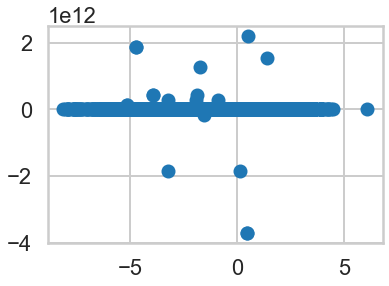

In [40]:
# Use the model to make predictions about our test data
y_pred= rModel.predict(X_test)
# Let's plot the predictions against the actual result. Use scatter()
plt.scatter(x=y_test, y=y_pred)

{'whiskers': [<matplotlib.lines.Line2D at 0x281928339d0>,
 'caps': [<matplotlib.lines.Line2D at 0x2819283f070>,
 'boxes': [<matplotlib.lines.Line2D at 0x28192833550>],
 'medians': [<matplotlib.lines.Line2D at 0x2819283f790>],
 'fliers': [<matplotlib.lines.Line2D at 0x2819283fb20>],
 'means': []}

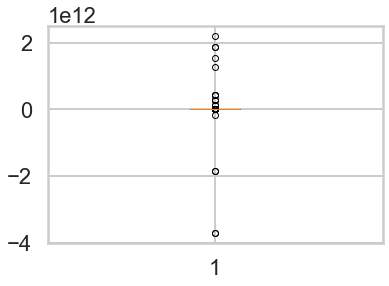

In [47]:
plt.boxplot(pd.DataFrame(y_pred))